In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
def rescale(df):
    df -= df.min()
    df /= df.max()
    return df

In [3]:
ppi_path = 'abundance_ppi_his3_edgotyping.tsv'
cp_path = '../../../results/Run7/2023_05_30_B1A1R1_protein_channel_f1score_agg.csv'

In [4]:
df_cp = pd.read_csv(cp_path)
df_ppi = pd.read_csv(ppi_path, sep='\t', header=0)

In [5]:
df_cp['Variant'] = df_cp['Variant'].apply(lambda x: x.split()[1])
df_ppi = df_ppi[df_ppi['symbol'].isin(df_cp.Gene.unique())].reset_index(drop=True)

In [6]:
df_merged = df_cp.merge(df_ppi, left_on=['Gene', 'Variant'], right_on=['symbol', 'aa_change'], how='inner')
df_merged['abs_z_abundance_change'] = df_merged['z_abundance_change'].apply(np.abs)

In [7]:
df_merged['abs_z_abundance_change'].corr(df_merged['F1_Score'])

0.01275305059924543

In [44]:
df_merged.groupby('Gene')['Variant'].count().idxmax()

'DES'

In [ ]:
for gene in tqdm(df_merged['Gene'].unique()):
    generate_figure(df_merged, gene)

In [59]:
chosen_gene = 'STXBP1'
df_chosen = df_merged[df_merged['Gene']==chosen_gene].reset_index(drop=True)

In [67]:
df_chosen['F1_Score'].max()

0.932793194958579

In [60]:
def colorcode(x):
    if x == 'Pathogenic':
        return 'red'
    elif x == 'Benign':
        return 'green'
    elif x == 'Conflicting':
        return 'gray'
    else: return 'blue'

In [61]:
color_dict = dict(zip(df_chosen['Variant'], df_chosen['clinical_significance'].apply(lambda x: colorcode(x))))

In [62]:
df_chosen_var = df_chosen[['Variant', 'F1_Score', 'z_abundance']].copy()
df_chosen_var.sort_values(by=['z_abundance'], inplace=True)
df_chosen_var.index = df_chosen_var['Variant']
df_chosen_var.drop ('Variant', axis=1, inplace=True)
df_chosen_var.dropna(inplace=True)

In [63]:
df_chosen_var['z_abundance'] = rescale(df_chosen_var['z_abundance'])
df_chosen_var['F1_Score'] = rescale(df_chosen_var['F1_Score'])
# df_chosen_var['z_abundance_change'] = rescale(df_chosen_var['z_abundance_change'])

In [65]:
df_chosen_var['z_abundance'].corr(df_chosen_var['F1_Score'])

0.7145668363672223

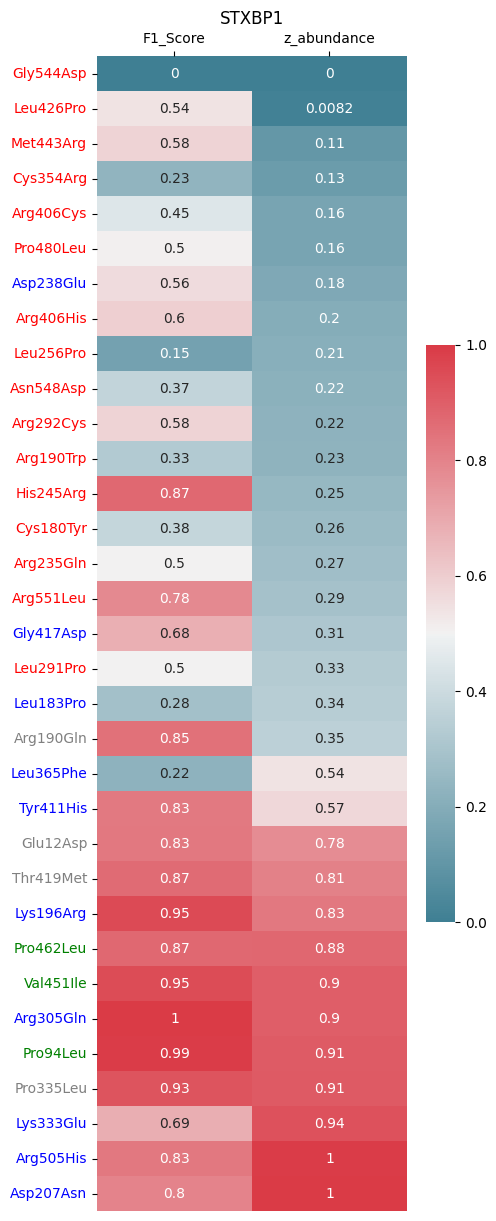

In [48]:
plt.figure(figsize=[5,15])
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(df_chosen_var, cmap=cmap, cbar_kws={"shrink": .5}, annot=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='major', labelsize=10)
for tick_label in ax.get_yticklabels():
    tick_label.set_color(color_dict[tick_label.get_text()])
ax.set_title(chosen_gene)
plt.savefig(f'fig/{chosen_gene}.png', format='png', bbox_inches='tight')
# ax.set_aspect(df_chosen_var.shape[1] / df_chosen_var.shape[0])